In [60]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.data.make_dataset import train_dataloader
from src.models.lit_node import NODE, ToyODE

Test on a sphere

In [201]:
def sphere_metric(theta, phi):
    return torch.tensor([[1, 0], [0, torch.sin(theta) ** 2]])


def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor

In [202]:
fn_ode = ToyODE(2, [20, 10, 10])
neural_ode = NODE(fn_ode, method="rk4")

In [203]:
x0 = torch.tensor([0.0, 0.0]).view(1, 2)
x1 = torch.tensor([pi, 0.0]).view(1, 2)

In [204]:
n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.0001)

In [208]:
neural_ode.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps).squeeze(1)

    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    cost = [torch.sqrt(p.T @ sphere_metric(*p) @ p) for p in path]
    loss = sum(cost) / len(cost) + pred_loss

    if epoch % 100 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(4.2623, grad_fn=<AddBackward0>)
tensor(1.2908, grad_fn=<AddBackward0>)
tensor(1.0732, grad_fn=<AddBackward0>)
tensor(1.0580, grad_fn=<AddBackward0>)
tensor(1.0450, grad_fn=<AddBackward0>)
tensor(1.0304, grad_fn=<AddBackward0>)
tensor(1.0139, grad_fn=<AddBackward0>)
tensor(0.9953, grad_fn=<AddBackward0>)
tensor(0.9555, grad_fn=<AddBackward0>)
tensor(0.9022, grad_fn=<AddBackward0>)


In [209]:
path = neural_ode(x0, n_steps).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())

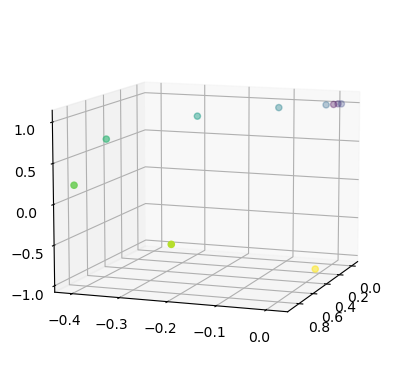

In [210]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.view_init(10, 20)
plt.show()

In [211]:
# Without the metric loss.
fn_ode = ToyODE(2, [5, 5])
neural_ode = NODE(fn_ode, method="rk4")

n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.0001)

neural_ode.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps).squeeze(1)

    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    loss = pred_loss

    if epoch % 20 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(0.8649, grad_fn=<MseLossBackward0>)
tensor(0.7369, grad_fn=<MseLossBackward0>)
tensor(0.6273, grad_fn=<MseLossBackward0>)
tensor(0.5332, grad_fn=<MseLossBackward0>)
tensor(0.4526, grad_fn=<MseLossBackward0>)
tensor(0.3833, grad_fn=<MseLossBackward0>)
tensor(0.3234, grad_fn=<MseLossBackward0>)
tensor(0.2718, grad_fn=<MseLossBackward0>)
tensor(0.2276, grad_fn=<MseLossBackward0>)
tensor(0.1899, grad_fn=<MseLossBackward0>)
tensor(0.1577, grad_fn=<MseLossBackward0>)
tensor(0.1303, grad_fn=<MseLossBackward0>)
tensor(0.1071, grad_fn=<MseLossBackward0>)
tensor(0.0876, grad_fn=<MseLossBackward0>)
tensor(0.0712, grad_fn=<MseLossBackward0>)
tensor(0.0576, grad_fn=<MseLossBackward0>)
tensor(0.0464, grad_fn=<MseLossBackward0>)
tensor(0.0372, grad_fn=<MseLossBackward0>)
tensor(0.0297, grad_fn=<MseLossBackward0>)
tensor(0.0235, grad_fn=<MseLossBackward0>)
tensor(0.0186, grad_fn=<MseLossBackward0>)
tensor(0.0145, grad_fn=<MseLossBackward0>)
tensor(0.0113, grad_fn=<MseLossBackward0>)
tensor(0.00

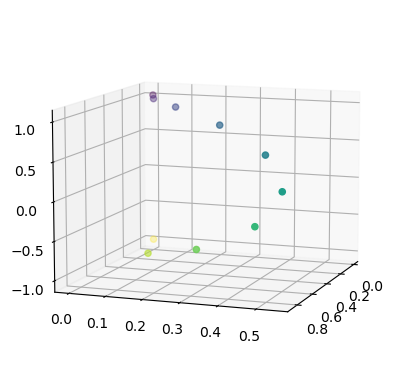

In [212]:
path = neural_ode(x0, n_steps).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.view_init(10, 20)
plt.show()